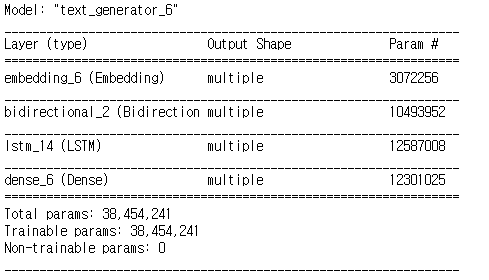

양방향레이어 때문인가? 로스는 효과적으로 감소했으나, 예측한 다음 단어를 안뱉는다...

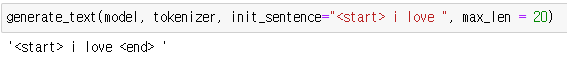

In [108]:
import tensorflow as tf
import re

## 데이터 읽어오기

In [109]:
import glob 
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path) 

raw_corpus = [] 

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['The first words that come out', 'And I can see this song will be about you', "I can't believe that I can breathe without you"]


## 데이터 정제

In [110]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

# print(preprocess_sentence("This @_is ;;;sample        sentence."))

corpus = []

for sentence in raw_corpus:
    
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    if len(sentence) > 15: continue   # 토큰 개수가 15개를 넘어가는 문장을 학습데이터에서 제외하기
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

## 평가 데이터셋 분리

In [111]:
from sklearn.model_selection import train_test_split

def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
   
    tokenizer.fit_on_texts(corpus)
   
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)

[[  2 404   5 ...   0   0   0]
 [  2 404   3 ...   0   0   0]
 [  2  27 177 ...   0   0   0]
 ...
 [  2   8   5 ...   0   0   0]
 [  2   8   5 ...   0   0   0]
 [  2   8   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7aedfd2f84f0>


## 인공지능 만들기

In [112]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [113]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, dropout=0.2)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True, dropout=0.2)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 256 
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [114]:
for src_sample, tgt_sample in dataset.take(1): break
    
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-8.54864193e-05,  2.76175560e-04,  2.98426203e-05, ...,
          3.44705360e-04, -3.68919398e-04, -2.75035680e-04],
        [-5.79339612e-05,  5.18931600e-04, -1.68162616e-04, ...,
          2.80367327e-04, -7.25140504e-04, -2.24687043e-04],
        [ 7.56469162e-05,  7.25449005e-04, -6.16080011e-04, ...,
          2.78917549e-04, -8.14627390e-04, -9.59761965e-05],
        ...,
        [-5.48255397e-04,  1.81031029e-03,  2.56758509e-03, ...,
         -1.23273907e-03,  8.60212778e-04,  4.47111437e-03],
        [-5.84317022e-04,  1.83775206e-03,  2.63211317e-03, ...,
         -1.32683187e-03,  8.95859848e-04,  4.62153833e-03],
        [-6.16652833e-04,  1.86100544e-03,  2.68411776e-03, ...,
         -1.40946894e-03,  9.26636800e-04,  4.74856608e-03]],

       [[-8.54864193e-05,  2.76175560e-04,  2.98426203e-05, ...,
          3.44705360e-04, -3.68919398e-04, -2.75035680e-04],
        [-2.38190565e-04,  5.81245811e-04, -3

In [115]:
model.summary()

Model: "text_generator_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_15 (LSTM)               multiple                  5246976   
_________________________________________________________________
lstm_16 (LSTM)               multiple                  8392704   
_________________________________________________________________
dense_7 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [123]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) 

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

# loss 감소를 위해 패딩 마스킹 적용
def loss_func(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss(real, pred)
    
    mask = tf.cast(mask, dtype = loss_.dtype)
    
    loss_ *= mask
    
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

# EarlyStopping
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True  
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,      
    patience=3,       
    min_lr=1e-6,      
    verbose=1
)


model.compile(loss=loss_func, optimizer=optimizer) 

history = model.fit(dataset, epochs=100 ,callbacks=[earlystopping, lr_scheduler], validation_data = val_dataset)

Epoch 1/100
55/55 [==============================] - 16s 238ms/step - loss: 3.7548 - val_loss: 3.5713
Epoch 2/100
55/55 [==============================] - 13s 234ms/step - loss: 3.5853 - val_loss: 3.4516
Epoch 3/100
55/55 [==============================] - 13s 241ms/step - loss: 3.4869 - val_loss: 3.3543
Epoch 4/100
55/55 [==============================] - 13s 237ms/step - loss: 3.4047 - val_loss: 3.2709
Epoch 5/100
55/55 [==============================] - 13s 231ms/step - loss: 3.3242 - val_loss: 3.1933
Epoch 6/100
55/55 [==============================] - 13s 229ms/step - loss: 3.2539 - val_loss: 3.1243
Epoch 7/100
55/55 [==============================] - 13s 229ms/step - loss: 3.1874 - val_loss: 3.0639
Epoch 8/100
55/55 [==============================] - 13s 231ms/step - loss: 3.1280 - val_loss: 3.0032
Epoch 9/100
55/55 [==============================] - 13s 233ms/step - loss: 3.0727 - val_loss: 2.9516
Epoch 10/100
55/55 [==============================] - 13s 234ms/step - loss: 3.026

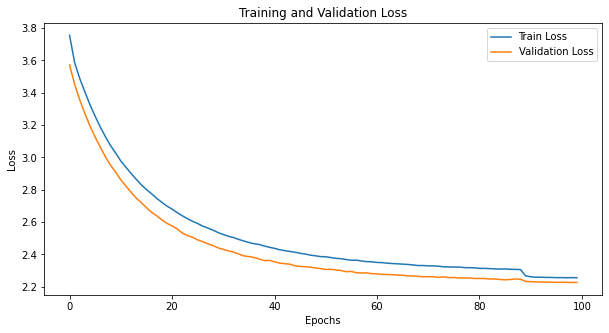

In [124]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

In [125]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): 
    
    test_input = tokenizer.texts_to_sequences([init_sentence]) 
    
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    
    end_token = tokenizer.word_index["<end>"]

    while True:
        
        predict = model(test_tensor) 
        
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [126]:
generate_text(model, tokenizer, init_sentence="<start> i love ", max_len = 20)

'<start> i love you <end> '